# Tutorial: Basic Usage

This tutorial demonstrates how to use `spefit` to fit the SPE function to a numpy array of charge.

In [1]:
from spefit.container import ChargeContainer
from spefit.pdf.pmt_single_gaussian import PMTSingleGaussian
from spefit.fitter import minimize_with_iminuit
from spefit.cost import BinnedNLL
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

/Users/Jason/Software/spefit/spefit/fitter.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


## The Dataset

Create a test dataset via inverse transform sampling from the single-photoelectron PDF for a simple PMT, at three seperate average illuminations λ (to utilise a simultaneous fit):

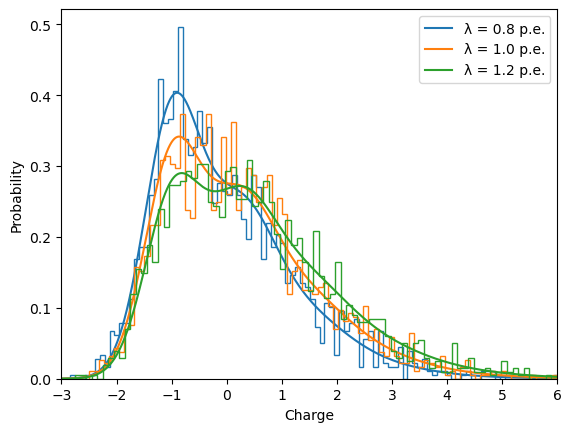

In [2]:
x = np.linspace(-5, 10, 10000)
illuminations = [0.8, 1.0, 1.2]
pdf = PMTSingleGaussian(n_illuminations=len(illuminations))
parameters = dict(eped=-1, eped_sigma=0.5, pe=1.2, pe_sigma=0.4)
charge_arrays = []

fig, ax = plt.subplots()
ax.set_xlabel("Charge")
ax.set_ylabel("Probability")

for i in illuminations:
    y = pdf.function(x, lambda_=i, **parameters)  # Calculate PDF via the direct call to the PDF function
    c = np.random.choice(x, p=y / y.sum(), size=2000)  # Inverse transform sampling
    charge_arrays.append(c)
    
    # Plot the spectrum
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(x, y, color=color, label=f"λ = {i} p.e.")
    ax.hist(c, bins=100, density=True, histtype='step', color=color)
    ax.set_xlim(-3, 6)

ax.legend()

## Prepare the Data

The first step in the fit process is to store the charge into the `ChargeContainer`, which prepares the charge for `spefit` (selecting the range of charge to fit, and creating this binned data for the binned negative log-likelihood and least-sqaures cost approaches. 

In [3]:
charges = [ChargeContainer(c, n_bins=100, range_=(-3, 6)) for c in charge_arrays]

## Perform the Fit

The `PDF` class defines the description of the SPE PDF, and handles everything to do with the multi-illumination simulateous fit.

The `Cost` class defines the function to be minimised, given a `PDF` class and the data (contained in the `ChargeContainer`), to obtain the best-fit parameters. `spefit` provides three minimisation approaches, described by the `Cost` subclasses:
1. Unbinned negative log-likelihood (`UnbinnedNLL`)
2. Binned negative log-likelihood (`BinnedNLL`)
3. Least-squares Chi-squared (`LeastSquares`)

Due to the Poisson nature of the counts in each bin, it is recommended to use the NLL methods. The `UnbinnedNLL` can be slower than `BinnedNLL` due to the evaluation of each charge, however it ensures no features are lost by a poor binning of the charges. Here we will demonstrate the `BinnedNLL` cost method.

In [4]:
pdf = PMTSingleGaussian(n_illuminations=len(charges))  # Define the PDF which is assumed to describe the dataset
pdf.update_parameters_initial(eped=-2, pe=2) # It is possible to update the initial values for the fit, potentially improving the result and execution time
print(pdf.initial)

{'eped': -2, 'eped_sigma': 0.1, 'pe': 2, 'pe_sigma': 0.1, 'lambda_0': 0.7, 'lambda_1': 0.7, 'lambda_2': 0.7}


In [5]:
cost = BinnedNLL(pdf, charges)  # Create the Cost class to be minimised
values, errors = minimize_with_iminuit(cost)

## Demonstrate Result

With the returned values from the fit, we can plot the resulting fit curve and obtain the score of the fit from the `Cost` class:

p-value = 0.58, reduced-chi2 = 0.98

eped = -0.91 ± 0.05
eped_sigma = 0.56 ± 0.02
pe = 1.32 ± 0.07
pe_sigma = 0.26 ± 0.11
lambda_0 = 0.68 ± 0.07
lambda_1 = 0.87 ± 0.09
lambda_2 = 1.03 ± 0.09


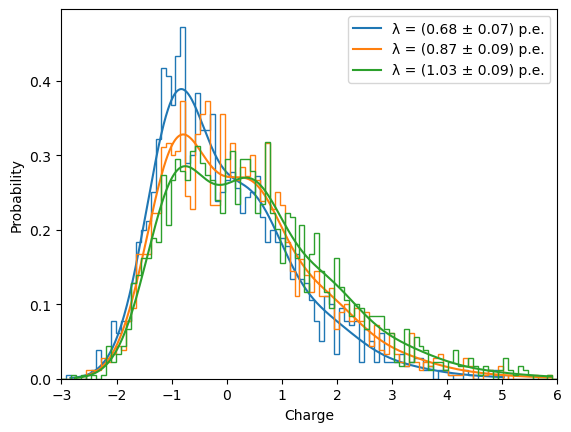

In [6]:
values_array = np.array(list(values.values()))
_, ax = plt.subplots()
ax.set_xlabel("Charge")
ax.set_ylabel("Probability")

for i in range(len(illuminations)):
    fit_x = np.linspace(charges[i].values.min(), charges[i].values.max(), 1000)
    fit_y = pdf(fit_x, values_array, i)  # Pass the values to the PDF class to obtain the best-fit curve for each illumination i
    
    lambda_ = values[f'lambda_{i}']
    lambda_err = errors[f'lambda_{i}']
    
    color = next(ax._get_lines.prop_cycler)['color']
    ax.plot(fit_x, fit_y, color=color, label=f"λ = ({lambda_:.2f} ± {lambda_err:.2f}) p.e.")
    ax.hist(charges[i].between, weights=charges[i].hist, bins=charges[i].edges, density=True, histtype='step', color=color)
    ax.set_xlim(-3, 6)
    
ax.legend()

print(f"p-value = {cost.p_value(values_array):.2f}, reduced-chi2 = {cost.reduced_chi2(values_array):.2f}\n")

for param in values.keys():
    print(f"{param} = {values[param]:.2f} ± {errors[param]:.2f}")